## Model selection - Zillow dataset forecasting

In [1]:
reset -fs

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

%config InlineBackend.figure_format = 'svg'

/Users/owner/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/owner/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Read, visualize raw data

In [3]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
df = pd.read_csv('../data/zillow-california.csv', parse_dates=['Date'])

#### Quick n dirty visualizations

In [5]:
df

,Date,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate,MedianRentalPrice_AllHomes.California
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN
5,2004-06-30,378461.35,5.66,6.7,NaN
6,2004-07-31,381175.00,5.46,7.3,NaN
7,2004-08-31,381925.00,5.26,7.5,NaN
8,2004-09-30,383775.00,5.14,6.4,NaN
9,2004-10-31,385900.00,5.12,6.5,NaN


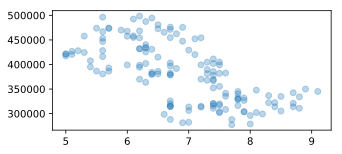

In [6]:
plt.figure(figsize=(5, 2.2))
plt.scatter(df['UnemploymentRate'], df['MedianSoldPrice_AllHomes.California'], alpha=0.3)
plt.show()

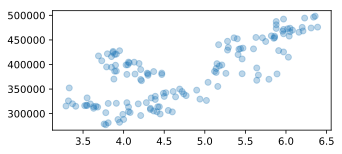

In [7]:
plt.figure(figsize=(5, 2.2))
plt.scatter(df['MedianMortageRate'], df['MedianSoldPrice_AllHomes.California'], alpha=0.3)
plt.show()

Correlations:
  - median mortgage rate
  - unemployment rate

In [8]:
sellprice = df['MedianSoldPrice_AllHomes.California']
sellprice.index = pd.DatetimeIndex(df['Date'])
sellprice.head()

Date
2004-01-31    326752.55
2004-02-29    329501.50
2004-03-31    340125.45
2004-04-30    355329.50
2004-05-31    367818.15
Name: MedianSoldPrice_AllHomes.California, dtype: float64

In [9]:
sellprice_not_na = sellprice[~sellprice.isna()]

#### Line, ACF plots

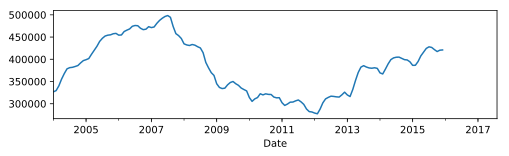

In [10]:
plt.figure(figsize=(8, 2))
sellprice.plot()
# plt.xticks(rotation=45)
plt.show()

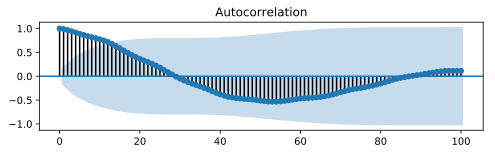

In [11]:
fig = plot_acf(sellprice_not_na, lags=100)
fig.set_size_inches(8, 2)
plt.show()

### Differencing

#### 1-time trend differencing

In [12]:
sellprice_d1 = pd.Series(np.diff(sellprice_not_na.values, n=1),
                           index=sellprice_not_na.index[1:])

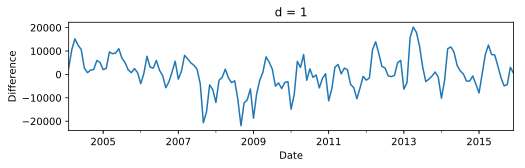

In [13]:
plt.figure(figsize=(8, 2))
sellprice_d1.plot()
plt.ylabel('Difference')
plt.title('d = 1')
plt.show()

In [14]:
adf_test(sellprice_d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 2-time trend differencing

In [15]:
sellprice_d2 = pd.Series(np.diff(sellprice_not_na.values, n=2),
                           index=sellprice_not_na.index[2:])

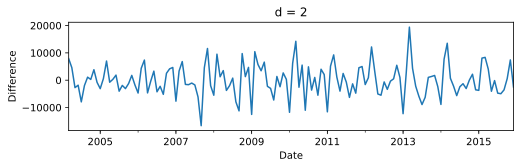

In [16]:
plt.figure(figsize=(8, 2))
sellprice_d2.plot()
plt.ylabel('Difference')
plt.title('d = 2')
plt.show()

In [17]:
adf_test(sellprice_d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


#### 3-time trend differencing

In [18]:
sellprice_d3 = pd.Series(np.diff(sellprice_not_na.values, n=3),
                           index=sellprice_not_na.index[3:])

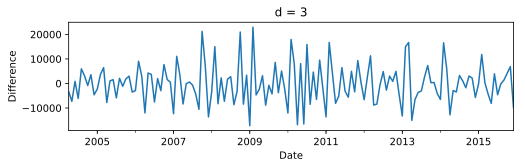

In [19]:
plt.figure(figsize=(8, 2))
sellprice_d3.plot()
plt.ylabel('Difference')
plt.title('d = 3')
plt.show()

In [20]:
adf_test(sellprice_d3)

Results of Dickey-Fuller Test:
Test Statistic                -7.368268e+00
p-value                        9.114125e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.260000e+02
Critical Value (1%)           -3.483346e+00
Critical Value (5%)           -2.884766e+00
Critical Value (10%)          -2.579156e+00
dtype: float64


#### 1-time seasonal differencing on 2-time trend differencing

There appears to be slight seasonality with lag 12, according to the 1-time differencing line plot.

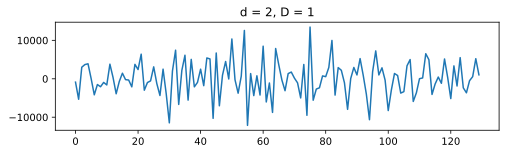

In [21]:
sellprice_d2_D1 = []
for i in range(12, len(sellprice_d2)):
    value = sellprice_d2[i] - sellprice_d2[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D1.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 1')
plt.plot(sellprice_d2_D1) 
plt.show()

In [22]:
adf_test(sellprice_d2_D1)

Results of Dickey-Fuller Test:
Test Statistic                  -5.149454
p-value                          0.000011
#Lags Used                      13.000000
Number of Observations Used    116.000000
Critical Value (1%)             -3.488022
Critical Value (5%)             -2.886797
Critical Value (10%)            -2.580241
dtype: float64


#### 2-time seasonal differencing on 2-time trend differencing

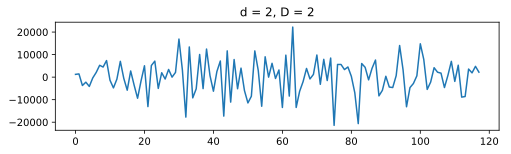

In [23]:
sellprice_d2_D2 = []
for i in range(12, len(sellprice_d2_D1)):
    value = sellprice_d2_D1[i] - sellprice_d2_D1[i - 12]  # lag is 12 (seasonal lag is 1 year, or 12 months)
    sellprice_d2_D2.append(value)
plt.figure(figsize=(8, 2))
plt.title('d = 2, D = 2')
plt.plot(sellprice_d2_D2) 
plt.show()

In [24]:
adf_test(sellprice_d2_D2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.224150
p-value                          0.000008
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


## Model selection with Auto-ARIMA

### d = 2, D = 2

In [25]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [26]:
model_d2_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=2, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=1786.789, BIC=1799.232, Fit time=1.277 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 2, 0, 12); AIC=1858.671, BIC=1863.649, Fit time=0.024 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 2, 0, 12); AIC=1861.609, BIC=1871.563, Fit time=0.232 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=1787.595, BIC=1797.549, Fit time=1.030 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 1, 12); AIC=1809.877, BIC=1824.809, Fit time=1.910 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 0, 12); AIC=1842.755, BIC=1852.709, Fit time=0.506 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 2, 2, 12); AIC=1810.096, BIC=1825.027, Fit time=2.596 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(1, 2, 2, 12); AIC=1813.069, BIC=1830.489, Fit time=2.930 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 2, 1, 12); AIC=1784.096, BIC=1799.028, Fit time=1.591 seconds
Fit ARIMA: order=(2, 2, 0) s

In [27]:
model_d2_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(2, 2, 1)x(0, 2, 1, 12)   Log Likelihood                -886.048
Date:                            Fri, 06 Dec 2019   AIC                           1784.096
Time:                                    17:01:04   BIC                           1799.028
Sample:                                         0   HQIC                          1790.115
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5681      9.166      0.280      0.779     -15.397      20.533
ar.L1          0.4812      0.124      3.868      0.000       0.237       0.725
ar.L2          0.1843      0.130      1.415      0.157      -0.071       0.440
ma.L1         -0.9973      0.747     -1.336      0.182      -2.460       0.466
ma.S.L12      -0.9887      0.729     -1.357      0.175      -2.417       0.439
sigma2      2.124e+07   3.89e-07   5.47e+13      0.000    2.12e+07    2.12e+07
===================================================================================
Ljung-Box (Q):                       40.88   Jarque-Bera (JB):                 2.16
Prob(Q):                              0.43   Prob(JB):                         0.34
Heteroskedasticity (H):               1.69   Skew:                             0.16
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+30. Standard errors may be unstable.
"""

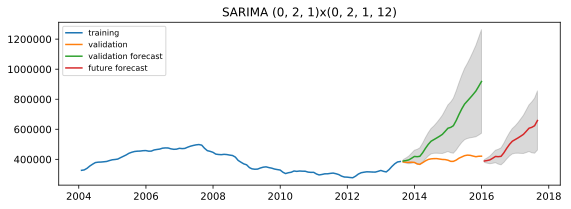

In [28]:
fc1, conf1 = model_d2_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d2_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (0, 2, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [29]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

248472.53


### d = 1, D = 2

**Best so far**

In [30]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [31]:
model_d1_D2 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=2, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1810.152, BIC=1822.651, Fit time=1.332 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=1887.649, BIC=1892.649, Fit time=0.022 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=1896.124, BIC=1906.124, Fit time=0.310 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1841.415, BIC=1851.414, Fit time=0.260 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=1825.971, BIC=1840.970, Fit time=0.648 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=1894.700, BIC=1904.699, Fit time=0.283 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=1826.015, BIC=1841.013, Fit time=1.372 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=1825.582, BIC=1843.081, Fit time=3.105 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=1809.072, BIC=1824.071, Fit time=1.501 seconds
Fit ARIMA: order=(2, 1, 0) s

In [32]:
model_d1_D2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(2, 1, 0)x(0, 2, 1, 12)   Log Likelihood                -896.109
Date:                            Fri, 06 Dec 2019   AIC                           1802.218
Time:                                    17:01:29   BIC                           1814.717
Sample:                                         0   HQIC                          1807.258
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     96.0627    161.289      0.596      0.551    -220.057     412.183
ar.L1          0.4503      0.140      3.221      0.001       0.176       0.724
ar.L2          0.1965      0.143      1.370      0.171      -0.085       0.478
ma.S.L12      -0.9994      0.153     -6.536      0.000      -1.299      -0.700
sigma2      2.571e+07   1.51e-05    1.7e+12      0.000    2.57e+07    2.57e+07
===================================================================================
Ljung-Box (Q):                       36.96   Jarque-Bera (JB):                 5.00
Prob(Q):                              0.61   Prob(JB):                         0.08
Heteroskedasticity (H):               1.43   Skew:                             0.43
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.95e+29. Standard errors may be unstable.
"""

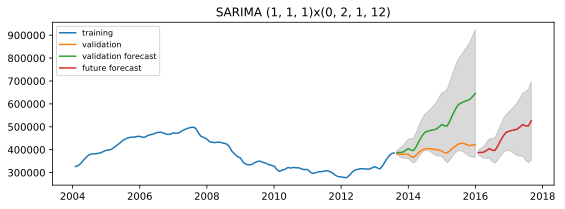

In [33]:
fc1, conf1 = model_d1_D2.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D2.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [34]:
mse = ((fc_series1 - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

121219.29


### d = 1, D = 1

**Not good!**

In [259]:
train_size = int(len(sellprice_not_na) * 0.80)
train, valid = sellprice_not_na[:train_size], sellprice_not_na[train_size:]
test = sellprice[sellprice.index >= pd.to_datetime('2016')]

In [260]:
model_d1_D1 = pm.auto_arima(train, start_p=1, start_q=1,
                            max_p=3, max_q=3, m=12,  # seasonal lag = 12
                            start_P=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2047.864, BIC=2060.989, Fit time=0.789 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2062.232, BIC=2067.482, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2079.005, BIC=2089.505, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2065.258, BIC=2075.758, Fit time=0.093 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2051.274, BIC=2067.023, Fit time=0.647 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2042.957, BIC=2053.457, Fit time=0.252 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2064.025, BIC=2071.900, Fit time=0.029 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2048.069, BIC=2061.194, Fit time=0.274 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2078.034, BIC=2085.909, Fit time=0.033 seconds
Fit ARIMA: order=(1, 1, 2) s

In [261]:
model_d1_D1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1017.478
Date:                            Mon, 02 Dec 2019   AIC                           2042.957
Time:                                    21:52:11   BIC                           2053.457
Sample:                                         0   HQIC                          2047.209
                                            - 115                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.6254     42.449      2.064      0.039       4.426     170.825
ar.L1          1.0000      0.016     62.954      0.000       0.969       1.031
ma.L1         -0.9228      0.011    -87.649      0.000      -0.943      -0.902
sigma2      2.649e+07    6.8e-05   3.89e+11      0.000    2.65e+07    2.65e+07
===================================================================================
Ljung-Box (Q):                      121.61   Jarque-Bera (JB):                 4.10
Prob(Q):                              0.00   Prob(JB):                         0.13
Heteroskedasticity (H):               1.09   Skew:                             0.17
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.8e+27. Standard errors may be unstable.
"""

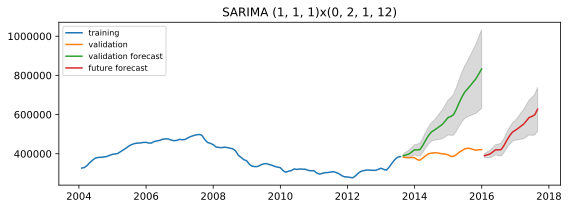

In [262]:
fc1, conf1 = model_d1_D1.predict(len(valid), return_conf_int=True, alpha=0.05)
fc2, conf2 = model_d1_D1.predict(len(test), return_conf_int=True, alpha=0.05)
fc_series1 = pd.Series(fc1, index=valid.index)
fc_series2 = pd.Series(fc2, index=test.index)

lower_series1 = pd.Series(conf1[:, 0], index=valid.index)
upper_series1 = pd.Series(conf1[:, 1], index=valid.index)
lower_series2 = pd.Series(conf2[:, 0], index=test.index)
upper_series2 = pd.Series(conf2[:, 1], index=test.index)

# Plot
plt.figure(figsize=(9, 3))
plt.plot(train, label='training')
plt.plot(valid, label='validation')
plt.plot(fc_series1, label='validation forecast')
plt.plot(fc_series2, label='future forecast')

plt.fill_between(lower_series1.index, lower_series1, upper_series1, color='k', alpha=.15)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.15)

plt.title('SARIMA (1, 1, 1)x(0, 2, 1, 12)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Evaluation

In [263]:
mse = ((fc_series - valid) ** 2).mean()
rmse=round(np.sqrt(mse), 2)
print(rmse)

188279.65
